# TTT4185 Machine learning for Speech technology

## Computer assigment 3b:  Regression analysis

Regression analysis is used to estimate/measure the relationship between an _independent_ variable, say $x$, and a _dependent_ variable, say $y$. One of the simplest regression problems is 
\begin{equation}
y = ax + b
\end{equation}
where $a$ and $b$ are constants. In practice our observations will be contaminated by noise, so we have
\begin{equation}
y = ax + b + n,
\end{equation}
where $n$ is noise, eg. measurement errors. This particular problem is called _linear regression_.

We will have a look at _non-linear regression_, using deep neural networks. Here we are looking at general regression problems in the form 
\begin{equation}
y = f(x) + n.
\end{equation}

We generate our data according to the function $f(x) = x^2 + \cos(20x) \text{ sign}(x)$, obtaining a set of observations $\{(x_i,y_i)\}$.

Then we assume we do not know the underlying function and we try to recover and approximation of $f$ only using the observations $\{(x_i,y_i)\}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

2023-10-26 11:50:55.416129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


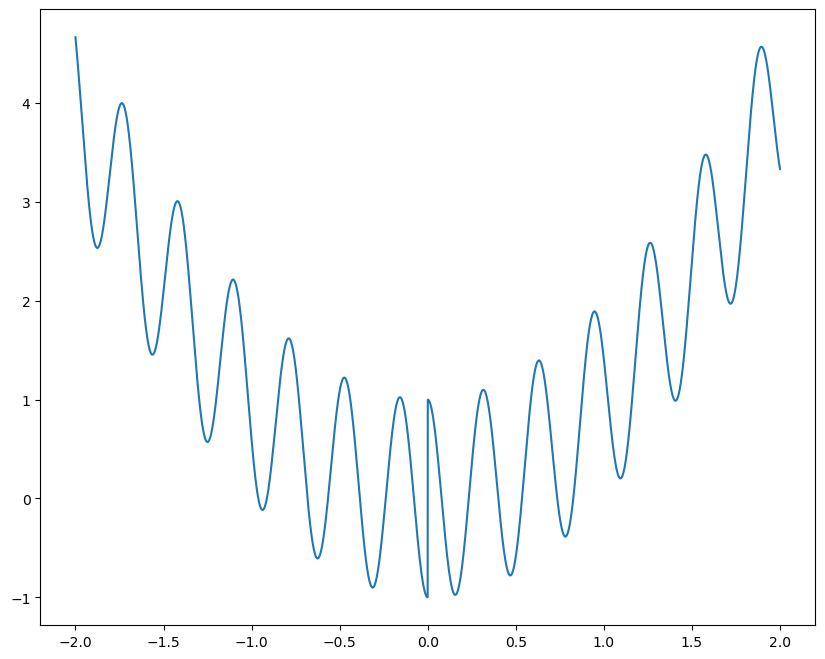

In [2]:
# Define function
def f(x):
    return x**2 + np.cos(20*x)*np.sign(x)

# Setup some simulation parameters
# Number of observations
N = 5000

# Plot a "clean" version of the relationship between x and y
plt.figure(figsize=(10, 8))
x = np.linspace(-2,2,N)
plt.plot(x,f(x))
plt.show()

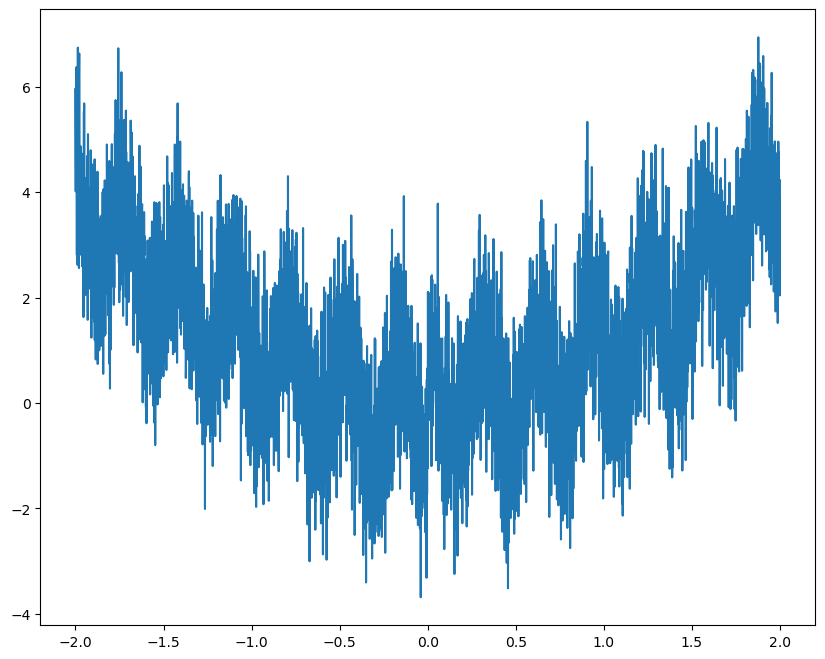

In [3]:
# Create a noise version of the observations
y = f(x) + np.random.randn(len(x))
plt.figure(figsize=(10, 8))
plt.plot(x,y)
plt.show()

One way to perform regression is to assume that the data is generated using a set of functions from a cerain family, for example polynomials of order $p$,
\begin{equation}
\hat f(x) = a_0 + a_1 x + a_2 x^2 \ldots a_p x^p.
\end{equation}
Then regression corresponds to fitting the parameters in the model. Let us see how this works out before using our neural networks.

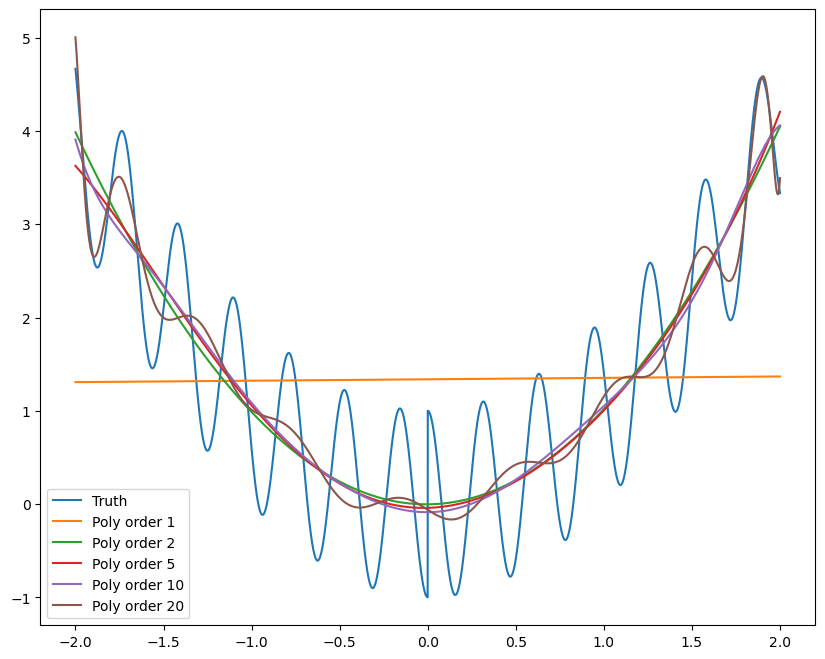

In [4]:
# Give a set of polynomial orders to try
P = [1, 2, 5, 10, 20]

# Define estimator function. Arguments are inout variable, observation and polynomial order
# Returns a set of polynomial coefficients
def reg_estimator(x,y,p):
    # Use simple ls approach
    N = len(x)
    H = np.zeros((N,p+1))
    for col in range(p+1):
        H[:,col] = x**col
    iHtH = np.linalg.inv(np.dot(H.T,H))
    theta = np.dot(np.dot(iHtH,H.T),y)
    return theta

# Computes fx) = c_0 + c_1x + c_2 x^2 ... c_p x^p
def poly(x, C):
    # compute p(x) for coeffs in c
    y = 0*x
    for p, c in enumerate(C):
        y += c*x**p        
    return y

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

## Problem 1
Play with different $p$ to see how close you can get to the true function.

Note: Very high $p$ will give numerical problems.

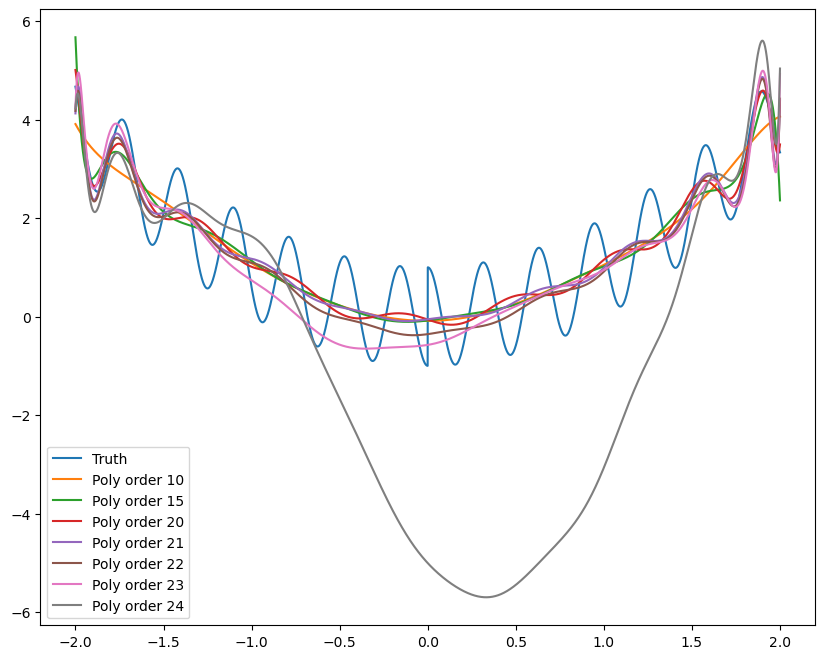

In [12]:
P2 = [10, 15, 20, 21, 22, 23, 24]

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P2:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

Should start using numerical solutions for order 23 and higher. Unsure how to do this.

In what follows we will use a deep neural network to approximate $f$. We set this up below

In [13]:
# Ceate a model with a single hidden layer. Note that input and output has
# dimension one
M = 512
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(1)
])

model.summary()
# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We train the network by using $x$ as an input and the squared error between the network output $\hat y$ and the observed value $y$ as a loss
\begin{equation}
 L = \frac{1}{N} \sum_n (\hat y - y)^2
\end{equation}

We first try our network on clean data to check if it works.

In [14]:
# train the model
history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=0)

Using the variable `history`, plot the evolution of the loss during training. 

157/157 [==============================] - 0s 2ms/step


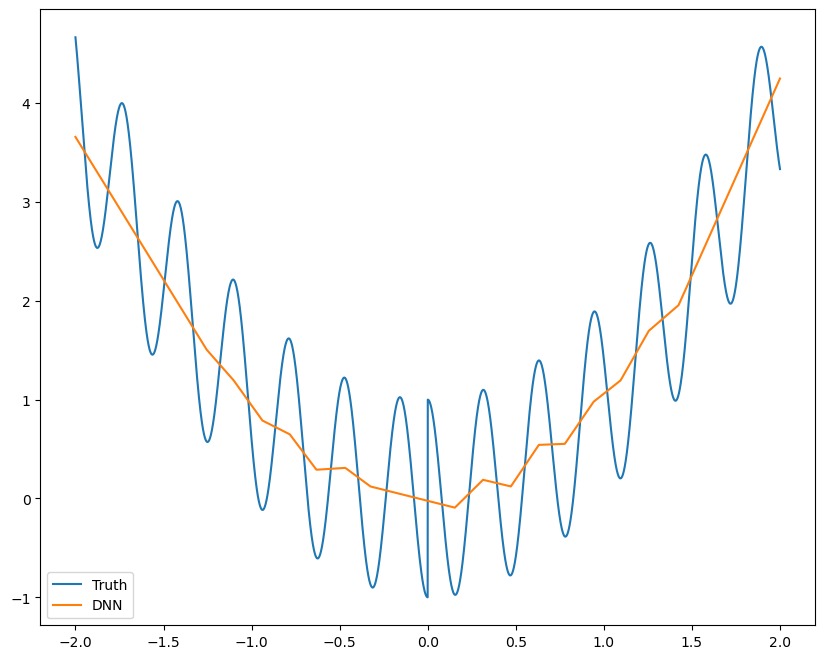

In [15]:
# Compute \hat y from the network and compare this to the true f(x)
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 2
Try increasing the number of nodes in the network to see if the results can be improved.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1536)              3072      
                                                                 
 dense_34 (Dense)            (None, 1)                 1537      
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [==============================] - 0s 1ms/step


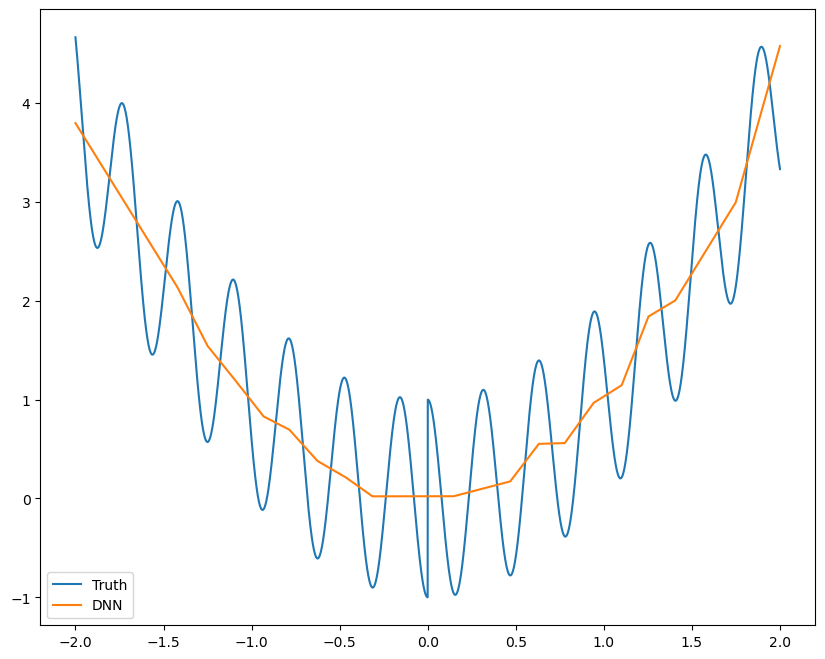

In [23]:
model_more_nodes = keras.Sequential([
    keras.layers.Dense(M*3, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(1)
])

model_more_nodes.summary()
# Train the model
model_more_nodes.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

# train the model
history_more_nodes = model_more_nodes.fit(x, f(x), epochs=1000, batch_size=128, verbose=0)

# Compute \hat y from the network and compare this to the true f(x)
z = model_more_nodes.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

Using more nodes does not improve performance, rather the opposite. This can be because of overfitting.

Next we will use a deep network with more than one hidden layer.

In [19]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 16
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                32        
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 865 (3.38 KB)
Trainable params: 865 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


157/157 [==============================] - 0s 955us/step


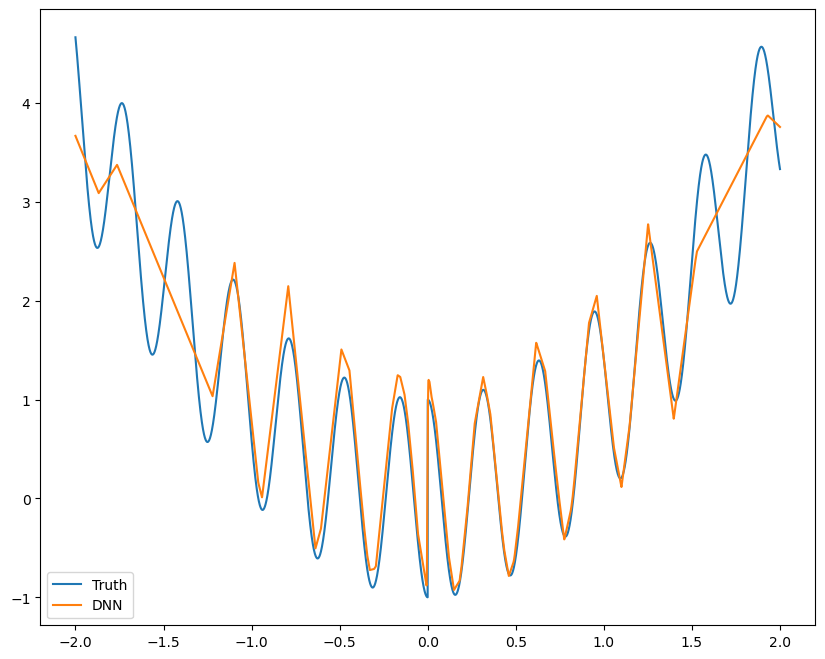

In [20]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 512)               1024      
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 132609 (518.00 KB)
Trainable params: 132609 (518.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [==============================] - 0s 1ms/step


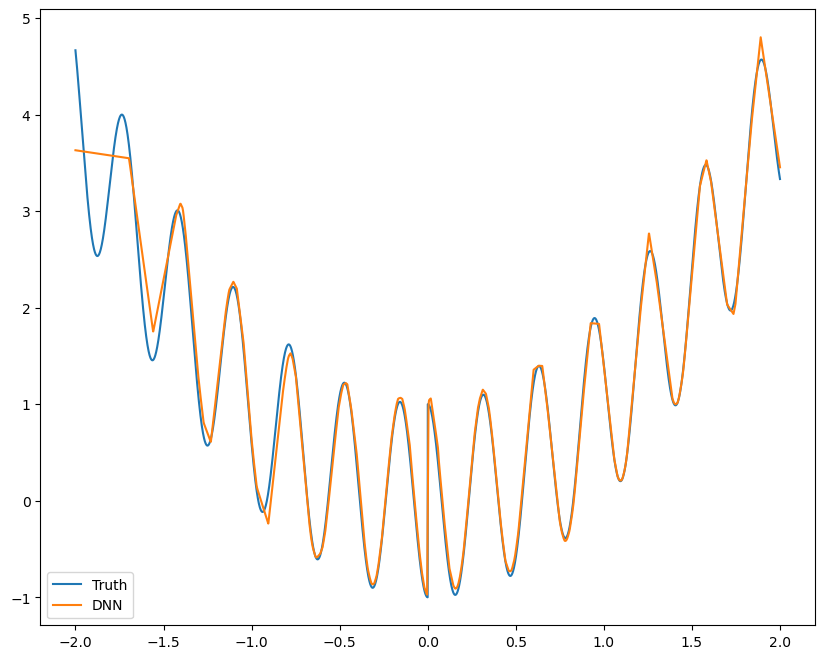

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 512)               1024      
                                                                 
 dense_30 (Dense)            (None, 256)               131328    
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dense_32 (Dense)            (None, 1)                 129       
                                                                 
Total params: 165377 (646.00 KB)
Trainable params: 165377 (646.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [==============================] - 0s 1ms/step


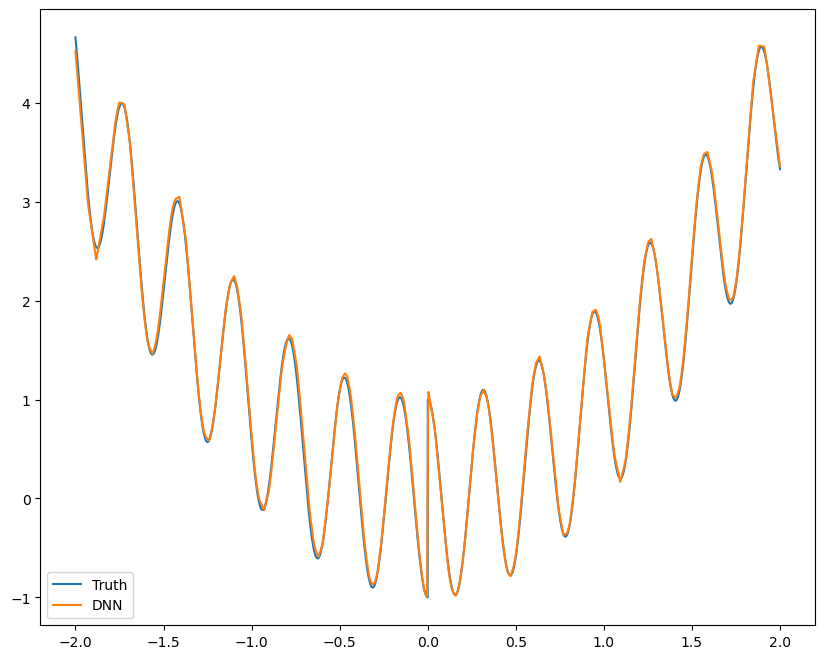

In [22]:
M = 512

# Two layers
model_two_layers = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M/2, activation=tf.nn.relu, input_dim=M),
    keras.layers.Dense(1)
])

model_two_layers.summary()
# Train the model
model_two_layers.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

# train the model
history_two_layers = model_two_layers.fit(x, f(x), epochs=1000, batch_size=128, verbose=0)

# Compute \hat y from the network and compare this to the true f(x)
z = model_two_layers.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

# Three layers
model_three_layers = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M/2, activation=tf.nn.relu, input_dim=M),
    keras.layers.Dense(M/4, activation=tf.nn.relu, input_dim=M/2),
    keras.layers.Dense(1)
])

model_three_layers.summary()
# Train the model
model_three_layers.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

# train the model
history_three_layers = model_three_layers.fit(x, f(x), epochs=1000, batch_size=128, verbose=0)

# Compute \hat y from the network and compare this to the true f(x)
z = model_three_layers.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

The performance increases when using two layers, however the loss is quite high for low values of x.

Three layers does improve the performance a lot. Using three layers seems to model the original function almost perfectly.

## Problem 3
Try increasing the number of hidden nodes per layer until performance is satisfactory. Can the same effect be achieved by just adding more layers?

157/157 [==============================] - 0s 3ms/step


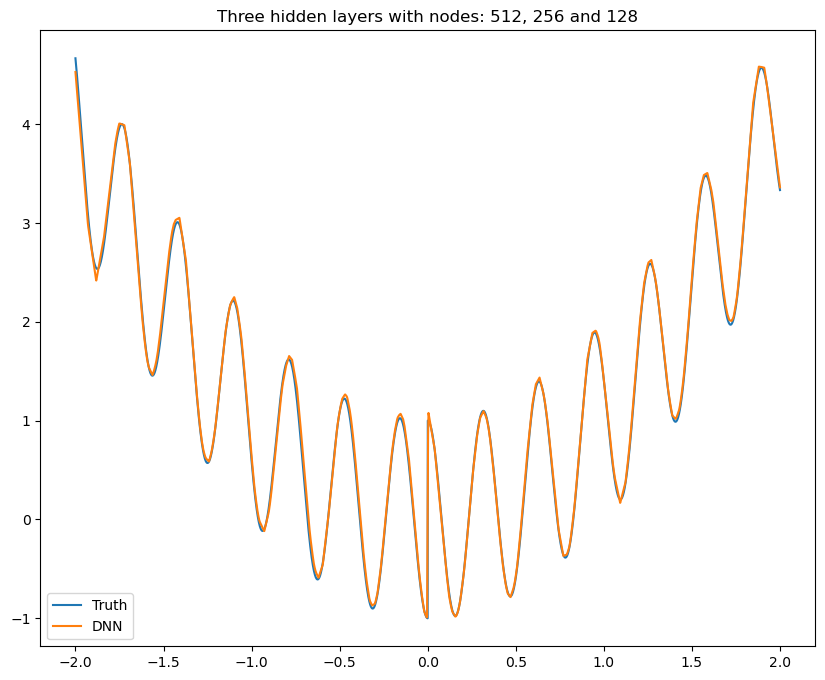

In [26]:
# Compute \hat y from the network and compare this to the true f(x)
z = model_three_layers.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.title("Three hidden layers with nodes: 512, 256 and 128")
plt.show()

This models the original function almost perfectly. Adding more layers does not improve the performance, because this can possibly lead to overfitting.

## Problem 4
Using the best setup from the previous problem, train a model using the noisy data.

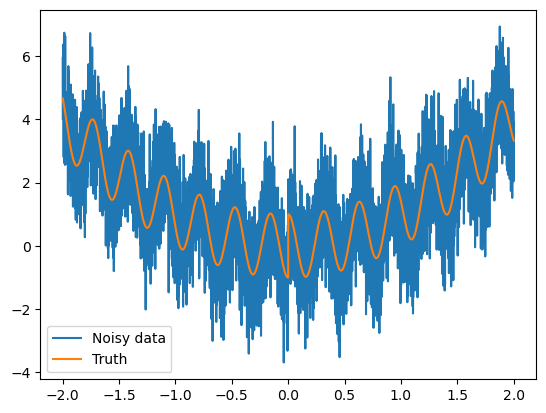

In [29]:
plt.plot(x, y)
plt.plot(x, f(x))
plt.legend(["Noisy data", "Truth"])
plt.show()

In [31]:
# Three layers
model_noisy = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M/2, activation=tf.nn.relu, input_dim=M),
    keras.layers.Dense(M/4, activation=tf.nn.relu, input_dim=M/2),
    keras.layers.Dense(1)
])

model_noisy.summary()
# Train the model
model_noisy.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 512)               1024      
                                                                 
 dense_40 (Dense)            (None, 256)               131328    
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 dense_42 (Dense)            (None, 1)                 129       
                                                                 
Total params: 165377 (646.00 KB)
Trainable params: 165377 (646.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


157/157 [==============================] - 0s 1ms/step


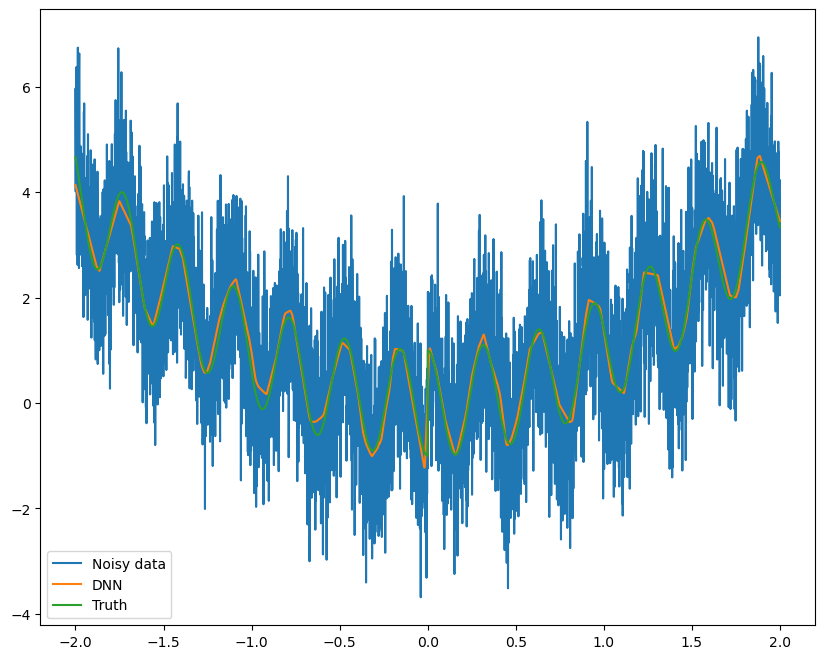

In [32]:
history_noisy = model_noisy.fit(x, y, validation_data=(x, f(x)), epochs=1000, batch_size=128, verbose=0)

z = model_noisy.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,y,label="Noisy data")
plt.plot(x,z,label="DNN")
plt.plot(x,f(x),label="Truth")
plt.legend()
plt.show()

Using the best setup from the previous problem, train a model using the noisy data. The performance is not as good as when using clean data, but it is still very good.